# 5-gestures-v2 model 

In [1]:
import os
from pathlib import Path
import numpy as np
from itertools import product
from tqdm.contrib import tenumerate
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
from dataset import Dataset
from model import Model
from evaluator import Evaluator

In [3]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load the data

In [4]:
SPLIT_THRESHOLD = 0.2
BATCH_SIZE = 32
SEED = 42

In [5]:
tf.random.set_seed(SEED)

In [6]:
data = Dataset(split_threshold=SPLIT_THRESHOLD, batch_size=BATCH_SIZE, path=Path('data/asl_final/full'), seed=SEED, labels=['C', 'G', 'H', 'nothing', 'Q', 'space'])

Found 540 files belonging to 6 classes.
Using 432 files for training.
Found 540 files belonging to 6 classes.
Using 108 files for validation.


In [7]:
images, _ = next(iter(data.train))
assert images.numpy().min() >= 0
assert images.numpy().max() <= 255
assert images.shape == (BATCH_SIZE, 256, 256, 3)

## Pre-processing

In [8]:
data.preprocess(resize=True, crop=False)

In [9]:
images, _ = next(iter(data.train))
assert images.numpy().min() >= 0
assert images.numpy().max() <= 255
assert images.shape == (BATCH_SIZE, 96, 96, 3)

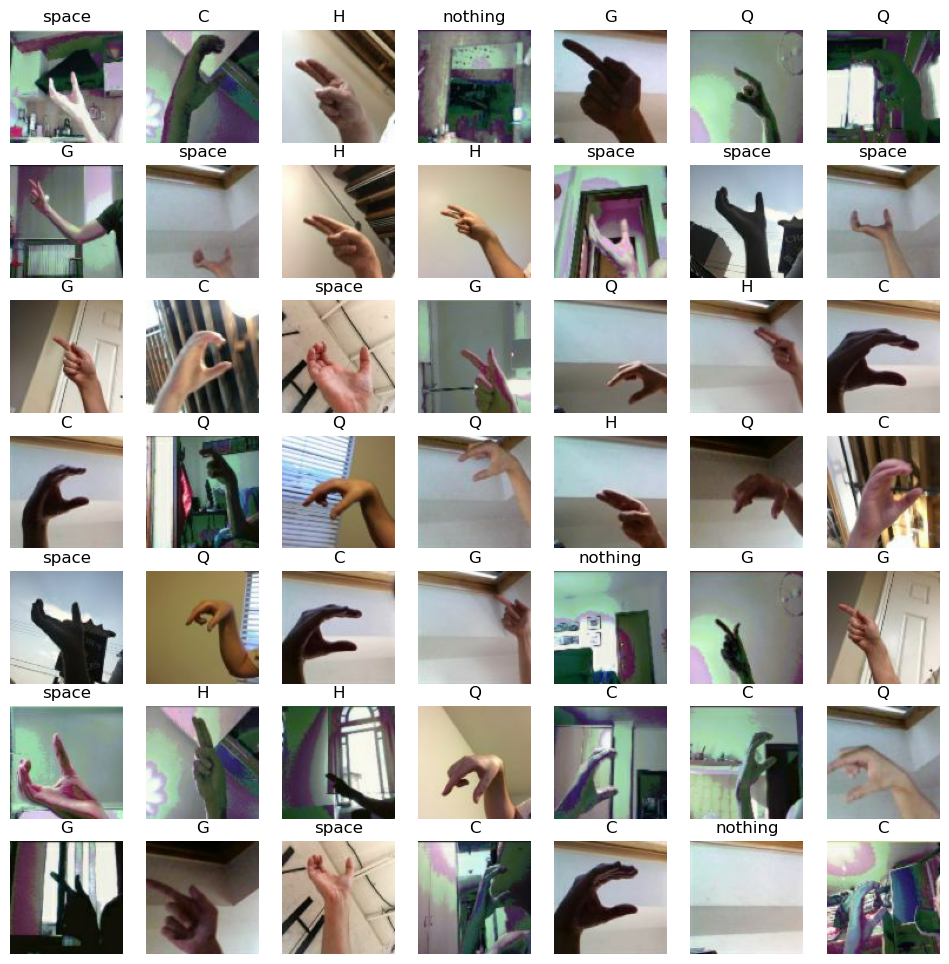

In [10]:
data.visualize_images('train', num_images=7)

In [11]:
data.plot_class_distribution('train', 100)

In [12]:
data.plot_class_distribution('validation', 100)

In [13]:
data.augment_and_rescale()

In [14]:
images, _ = next(iter(data.train))
assert images.numpy().min() >= -1
assert images.numpy().max() <= 1
assert images.shape == (BATCH_SIZE, 96, 96, 3)

In [15]:
data.cache()

## Train the model

Hyperparameters tuning:

In [16]:
fe_dropouts = [1e-3, 2.5e-3, 5e-3, 7.5e-3, 1e-2, 2.5e-2, 5e-2, 7.5e-2, 1e-1]
dense_dropouts = np.arange(start=0.0, stop=1.0, step=0.05)
fit_lrs = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
fine_tuning_lrs = [1e-7, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3]

Helper function to train a new model and save the results:

In [17]:
def run_experiment(exp_id, fe_dropout, dense_dropout, fit_lr, fine_tuning_lr):
    log_str = f'id={exp_id}-fe_d={fe_dropout}-dense_d={dense_dropout}-fit_lr={fit_lr}-ft_lr={fine_tuning_lr}'
    # Instantiate a new model 
    model = Model(num_classes=len(data.class_labels), fe_dropout_rate=fe_dropout, dense_dropout_rate=dense_dropout)
    # Compile and fit the model
    model.compile(learning_rate=fit_lr)
    model.fit(data.train, data.validation, epochs=30, log_dir=Path('logs/fit') / log_str)
    # Fine-tune the model
    # model.fine_tune(data.train, data.validation, epochs=30, learning_rate=fine_tuning_lr, log_dir=Path('logs/fine-tuning') / log_str)

In [18]:
def run_experiment_fit_only(exp_id, dense_dropout, fit_lr):
    log_str = f'id={exp_id}-dense_d={dense_dropout}-fit_lr={fit_lr}'
    # Instantiate a new model 
    model = Model(num_classes=len(data.class_labels), dense_dropout_rate=dense_dropout)
    # Compile and fit the model
    model.compile(learning_rate=fit_lr)
    model.fit(data.train, data.validation, epochs=150, log_dir=Path('logs/fit') / log_str)

Run experiments with a random search over the hyperparameters space:

In [19]:
combinations = list(product(dense_dropouts, fit_lrs))
np.random.shuffle(combinations)

In [20]:
# n_experiments = 100
# for i, (fe_d, dense_d, f_lr, ft_lr) in tenumerate(combinations[:n_experiments]):
#     tf.random.set_seed(SEED)
#     run_experiment(i, fe_d, dense_d, f_lr, ft_lr)

In [21]:
# n_experiments = len(combinations)
# for i, (dense_d, f_lr) in tenumerate(combinations[:n_experiments]):
#     tf.random.set_seed(SEED)
#     run_experiment_fit_only(i, dense_d, f_lr)

## Re-train the best model

In [22]:
tf.random.set_seed(SEED)

In [23]:
model = Model(num_classes=len(data.class_labels), dense_dropout_rate=0.7)

In [24]:
model.compile(learning_rate=1e-4)
model.fit(data.train, data.validation, epochs=100, log_dir=Path('logs/fit'))

Epoch 1/100
14/14 [==============================] - 5s 159ms/step - loss: 6.5312 - accuracy: 0.1620 - val_loss: 3.5173 - val_accuracy: 0.1759
Epoch 2/100
14/14 [==============================] - 1s 65ms/step - loss: 6.2050 - accuracy: 0.1921 - val_loss: 3.2405 - val_accuracy: 0.1759
Epoch 3/100
14/14 [==============================] - 1s 48ms/step - loss: 6.0877 - accuracy: 0.1898 - val_loss: 3.0120 - val_accuracy: 0.2037
Epoch 4/100
14/14 [==============================] - 1s 48ms/step - loss: 5.6685 - accuracy: 0.1852 - val_loss: 2.8556 - val_accuracy: 0.2593
Epoch 5/100
14/14 [==============================] - 1s 47ms/step - loss: 5.3732 - accuracy: 0.2060 - val_loss: 2.6887 - val_accuracy: 0.2778
Epoch 6/100
14/14 [==============================] - 1s 45ms/step - loss: 5.8292 - accuracy: 0.1921 - val_loss: 2.5749 - val_accuracy: 0.3148
Epoch 7/100
14/14 [==============================] - 1s 42ms/step - loss: 5.2567 - accuracy: 0.2245 - val_loss: 2.4637 - val_accuracy: 0.3333
Epoch

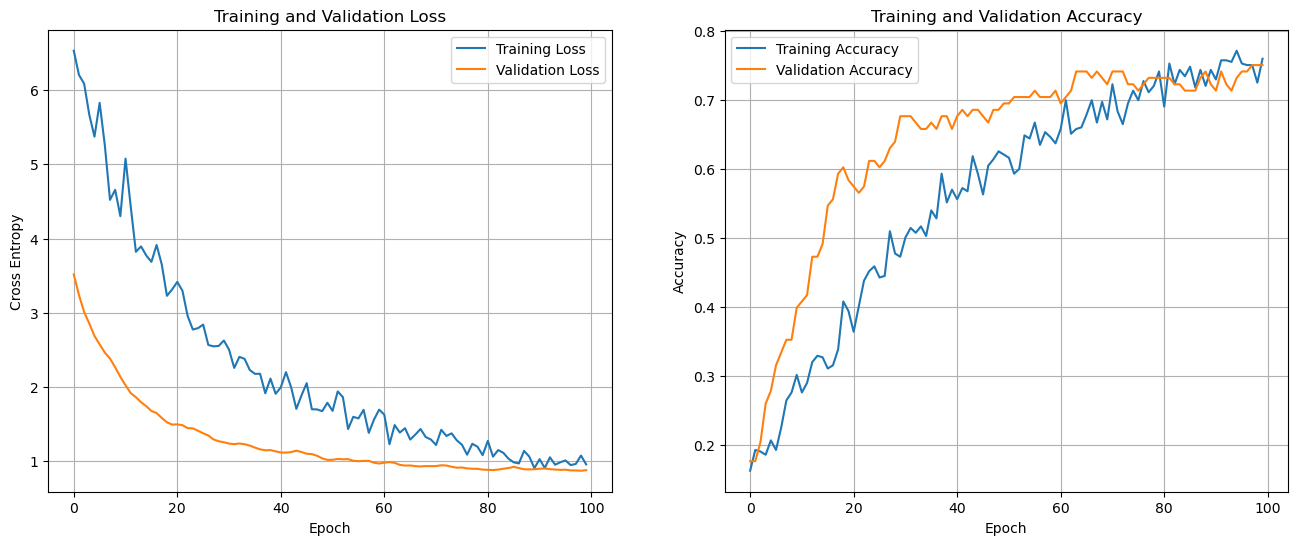

In [25]:
model.plot_history('fit')

In [26]:
# model.fine_tune(data.train, data.validation, epochs=50, learning_rate=1e-5, log_dir=Path('logs/fine-tuning'))

In [27]:
# model.plot_history('fine_tuning')

In [28]:
model.save(Path('models/5-gestures-v2'))

INFO:tensorflow:Assets written to: models/5-gestures-v2/asl_mobilenet_tuned/assets


INFO:tensorflow:Assets written to: models/5-gestures-v2/asl_mobilenet_tuned/assets


## Evaluation on the validation set

In [29]:
valid_evaluator = Evaluator(model.model, data.validation, data.class_labels)

100%|██████████| 4/4 [00:00<00:00,  7.10it/s]


In [30]:
valid_evaluator.evaluate()

Loss function: 9.011
Accuracy: 75.00%


In [31]:
valid_evaluator.confusion_matrix(size=800, save_path='figures/5_v2_cm.png')

In [32]:
valid_evaluator.relative_errors(save_path='figures/5_v2_errors.png')

## Quantization and evaluation

In [33]:
model.quantize(data.train, Path('models'))

INFO:tensorflow:Assets written to: temp/model/assets


INFO:tensorflow:Assets written to: temp/model/assets
fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


In [34]:
interpreter = tf.lite.Interpreter(model_path='models/asl_mobilenet_quant.tflite')
quant_evaluator = Evaluator(interpreter, data.validation, data.class_labels, quantized=True)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
108it [00:00, 879.50it/s]


In [35]:
quant_evaluator.evaluate()

Loss function: 8.343
Accuracy: 76.85%


In [36]:
quant_evaluator.confusion_matrix(size=800, save_path='figures/5_v2_cm_quant.png')

In [37]:
quant_evaluator.relative_errors(save_path='figures/5_v2_errors_quant.png')